In [1]:
from model.initial_prediction import GNNPolicy as predictModel
from model.neighborhood_search import GNNPolicy as searchModel
from tqdm.notebook import tqdm

import os
import torch
from uc_class import UC
import numpy as np
import json
from utilities import *
import copy
import time



In [2]:

DEVICE = 'cpu'
instance = '1080_8_std'

predict_path_3bin = 'model_save/initial_prediction/model.pth'
predict_model_3bin = predictModel()
predict_dict_3bin = torch.load(predict_path_3bin,map_location=DEVICE)
predict_model_3bin.load_state_dict(predict_dict_3bin)
predict_model_3bin.eval()

search_path_3bin_con = f'model_save/neighborhood_search/model.pth'
search_model_3bin_con = searchModel().to(DEVICE)
state_dict_3bin_con = torch.load(search_path_3bin_con,map_location=DEVICE)
search_model_3bin_con.load_state_dict(state_dict_3bin_con)
search_model_3bin_con.eval()

time_limit = 200

print("")

In [3]:
uc_path = f'./UC_AF/{instance}.mod'
uc = UC(uc_path)

shut_down = uc.Pishutdown
startup = uc.Pistartup
on = uc.ThTime_on_min
off = uc.ThTime_off_min
pmax = uc.ThPimax
pmin = uc.ThPimin
ramp_up = uc.Piup
ramp_down = uc.Pidown

N = uc.NumThermal
T = uc.HorizonLen
nums = np.array(uc.nums)
un = len(nums)


In [4]:
json_test_path = f'./datasets/{instance}/json/test/'
test_files = os.listdir(json_test_path)

In [5]:
save_path = f'data_save/IP-LNS'
json_test_path = f'./datasets/{instance}/json/test/'
test_files = os.listdir(json_test_path)
onls=np.maximum(uc.ThTime_on_min,uc.ThTime_off_min)
os.makedirs(save_path,exist_ok=True)
for file in tqdm(test_files):
    print(file)
    with open(os.path.join(json_test_path, file),'r') as f:
        data = json.load(f)
    m3 = uc.get_3bin_model(data)

    Tri_graph=get_Tripartite_graph_lp(m3)

    begin = time.time()
    sol_o = predict_model_3bin(Tri_graph).detach().cpu().numpy().reshape(-1)

    sol_o, sol_s, last = restore(sol_o,uc,data,m3)
    ftime = time.time()-begin
    times=[ftime]
    objs=[last]
    low = 0.1
    upper = 0.9
    local = np.where((sol_o>=low) & (sol_o<=upper),1,0)
    sol_s,ls_objs,ls_times = local_search(m3, sol_s, local,begin, TLE=20)

    times.extend(ls_times)
    objs.extend(ls_objs)
    obj, loop_times, time_round,obj_round,sol_s  = local_search_repeat(m3,search_model_3bin_con,sol_s,begin, onls,out=50,TLE = time_limit,search_time=40,log=True)

    times.extend(time_round)
    objs.extend(obj_round)
    print(objs[-1])
    np.savez('./'+save_path+f'/{file[:-5]}.npz',time_round=times, obj_round=objs)


  0%|          | 0/36 [00:00<?, ?it/s]

107_0.json
49281614.91066736
117_0.json
70602898.78656799
127_0.json
71142584.16395262
137_0.json
75682537.12435406
147_0.json
76390022.3031527
157_0.json
63547461.4730962
167_0.json
76907988.85144228
177_0.json
65004433.531354606
17_0.json
44393867.67818285
187_0.json
76658870.67521694
197_0.json
76329189.09624888
207_0.json
74575506.16919528
217_0.json
60964177.495331034
227_0.json
62179128.22754091
237_0.json
75173377.96732019
247_0.json
65008528.53216147
257_0.json
70733706.5130175
267_0.json
70525898.3477096
277_0.json
67183937.04526186
27_0.json
65084775.36446221
287_0.json
72482981.08432296
297_0.json
56877708.16929709
307_0.json
66542105.596322216
317_0.json
65787200.975616485
327_0.json
56964220.59259388
337_0.json
64271414.209928304
347_0.json
60334490.00632252
357_0.json
63402717.90227844
37_0.json
51130071.07622277
47_0.json
65058673.46229665
57_0.json
90238048.98381115
67_0.json
47879753.51738018
77_0.json
69798041.71171135
7_0.json
53554975.53729074
87_0.json
49346833.631

In [6]:
save_path = f'data_save/WS'
onls=np.maximum(uc.ThTime_on_min,uc.ThTime_off_min)
os.makedirs(save_path,exist_ok=True)
for file in tqdm(test_files):
    print(file)
    with open(os.path.join(json_test_path, file),'r') as f:
        data = json.load(f)
    m3 = uc.get_3bin_model(data)
    Tri_graph=get_Tripartite_graph_lp(m3)
    begin = time.time()
    sol_o = predict_model_3bin(Tri_graph).detach().cpu().numpy().reshape(-1)
    sol_o, sol_s, last = restore(sol_o,uc,data,m3)
    ftime = time.time()-begin
    times=[ftime]
    objs=[last]
    sol_s,ls_objs,ls_times = local_search(m3, sol_s, np.ones_like(sol_s,dtype=int), begin, TLE=max(20,time_limit-(time.time()-begin)))
    times.extend(ls_times)
    objs.extend(ls_objs)
    print(objs[-1])

    np.savez('./'+save_path+f'/{file[:-5]}.npz',time_round=times, obj_round=objs)


  0%|          | 0/36 [00:00<?, ?it/s]

107_0.json
49199955.35622406
117_0.json
70752189.59151751
127_0.json
71150096.8846078
137_0.json
75645588.30530126
147_0.json
76378672.81928512
157_0.json
62803900.07673928
167_0.json
76876324.48511212
177_0.json
64912233.42747654
17_0.json
44383313.72818282
187_0.json
76578584.06795117
197_0.json
76318322.13717112
207_0.json
74624899.0205065
217_0.json
60871603.10083697
227_0.json
62171253.5593503
237_0.json
75124620.90469511
247_0.json
64931916.93216156
257_0.json
70717885.41067925
267_0.json
70477799.49770966
277_0.json
67202879.76025547
27_0.json
65085265.56446238
287_0.json
72505855.9977003
297_0.json
56886626.66929755
307_0.json
66558784.87743446
317_0.json
65788036.37561673
327_0.json
56847581.82183822
337_0.json
64237575.438222446
347_0.json
60326240.45632287
357_0.json
63404510.45227853
37_0.json
51123580.93519907
47_0.json
65053041.46229683
57_0.json
89900152.28317343
67_0.json
47877803.047272995
77_0.json
69770207.21129467
7_0.json
53551433.687290706
87_0.json
49338349.28182

In [7]:
save_path = f'data_save/IP_WS'

onls=np.maximum(uc.ThTime_on_min,uc.ThTime_off_min)

os.makedirs(save_path,exist_ok=True)
for file in tqdm(test_files):
    print(file)
    with open(os.path.join(json_test_path, file),'r') as f:
        data = json.load(f)
    m3 = uc.get_3bin_model(data)
    Tri_graph=get_Tripartite_graph_lp(m3)
    begin = time.time()
    sol_o = predict_model_3bin(Tri_graph).detach().cpu().numpy().reshape(-1)
    sol_o, sol_s, last = restore(sol_o,uc,data,m3)
    ftime = time.time()-begin
    times=[ftime]
    objs=[last]
    low = 0.1
    upper = 0.9
    local = np.where((sol_o>=low) & (sol_o<=upper),1,0)
    sol_s,ls_objs,ls_times = local_search(m3, sol_s, local,begin, TLE=20)
    times.extend(ls_times)
    objs.extend(ls_objs)
    #warmstart 
    sol_s,ls_objs,ls_times = local_search(m3, sol_s, np.ones_like(local,dtype=int), begin, TLE=max(20,time_limit-(time.time()-begin)))
    times.extend(ls_times)
    objs.extend(ls_objs)
    print(objs[-1])

    np.savez('./'+save_path+f'/{file[:-5]}.npz',time_round=times, obj_round=objs)

  0%|          | 0/36 [00:00<?, ?it/s]

107_0.json
49209797.608637005
117_0.json
70675560.42628795
127_0.json
71145227.76395302
137_0.json
75648476.33774811
147_0.json
76376429.47672488
157_0.json
62804086.12673908
167_0.json
76878065.12661321
177_0.json
64892065.7326943
17_0.json
44383313.72818282
187_0.json
76573184.11622508
197_0.json
76310208.93717116
207_0.json
74605850.63131416
217_0.json
60860022.62496125
227_0.json
62169639.92550034
237_0.json
75128776.30054028
247_0.json
64939166.18216165
257_0.json
70716368.85960361
267_0.json
70486280.29770967
277_0.json
67184945.92158163
27_0.json
65086257.56446237
287_0.json
72445580.21361275
297_0.json
56893868.46929757
307_0.json
66543953.78250921
317_0.json
65788036.37561673
327_0.json
56847581.82183822
337_0.json
64231299.48822244
347_0.json
60326547.585888036
357_0.json
63404510.45227853
37_0.json
51124014.38519905
47_0.json
65051285.84972897
57_0.json
89937692.6608838
67_0.json
47878363.59727298
77_0.json
69770207.21129467
7_0.json
53552367.83729072
87_0.json
49356204.2043

In [8]:
save_path = f'data_save/Gurobi'
os.makedirs(save_path,exist_ok=True)

for file in tqdm(test_files):
    with open(os.path.join(json_test_path, file),'r') as f:
        data = json.load(f)
    m3 = uc.get_3bin_model(data)
    vars = m3.getVars()
    u = [v for v in vars if v.varName[0]=='u']
    m3.Params.OutputFlag = 0
    m3.Params.TimeLimit = time_limit
    m3.Params.Threads = 1
    m3._start_time=time.time()
    m3._objs=[]
    m3._times=[]
    m3._sols=[]
    m3._u=u
    m3.optimize(cmp_sol)
    print(m3.ObjVal)
    np.savez('./'+save_path+f'/{file[:-5]}.npz',time_round=m3._times, obj_round=m3._objs, gap=m3.MIPGap)

    

  0%|          | 0/36 [00:00<?, ?it/s]

49199955.35622408
70762091.57628796
71149476.68460783
75650699.40257534
76379051.91928509
62805337.19847601
76877068.51098412
64970388.943019114
44383313.728182845
76578584.06795119
76313829.97700667
74632584.08759357
60907037.20083681
62183720.10094522
75124720.94630523
64931857.482161574
70715608.65960373
70486116.59770972
67202879.7602554
65084966.56446239
72497558.95909528
56882483.26929758
66555065.87601833
65788036.37561665
56854438.97145948
64237575.43822246
60325069.55219091
63404510.45227855
51122679.58519907
65054449.11769302
89894688.10835786
47875485.19727075
69770207.21129467
53551433.68729073
49347441.131828725
66045865.71208144


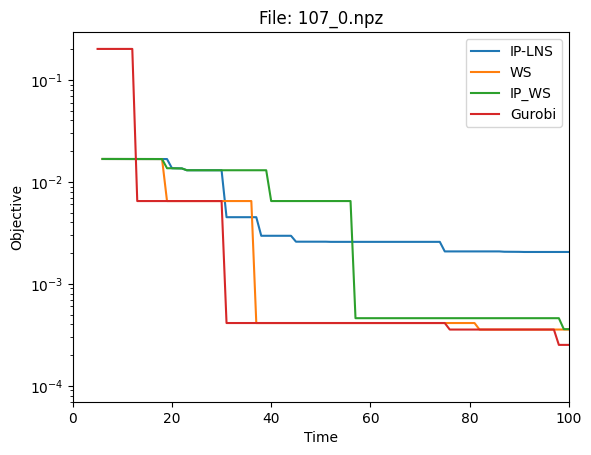

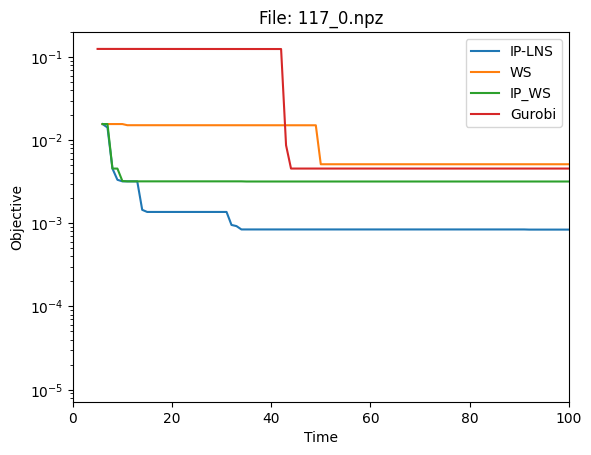

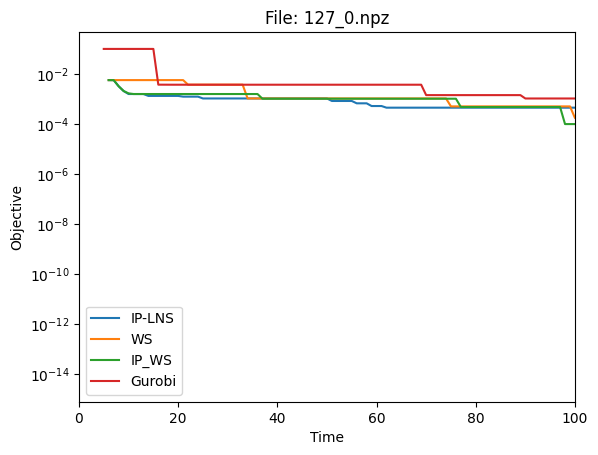

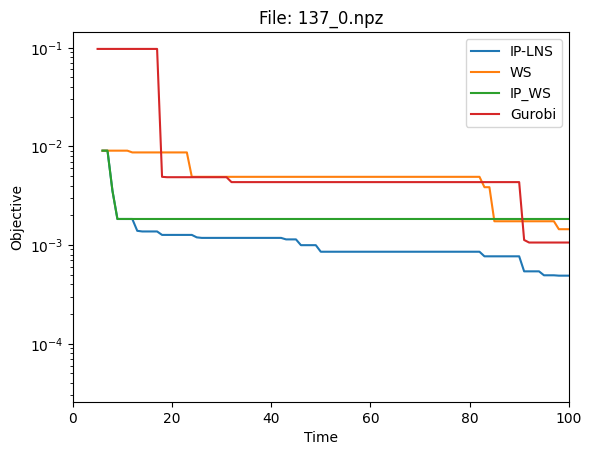

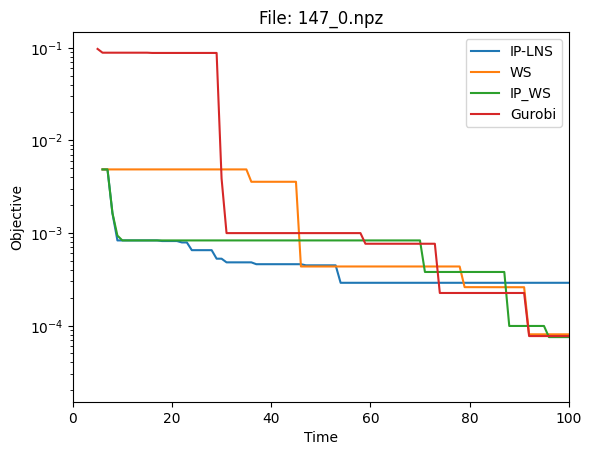

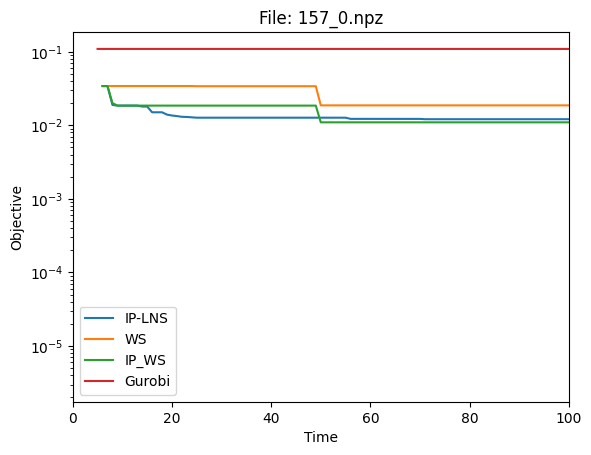

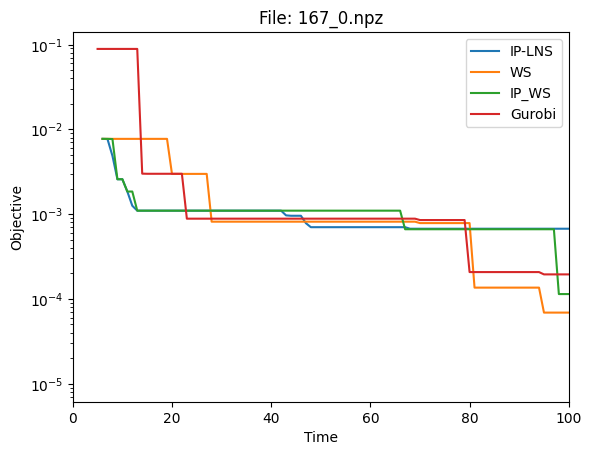

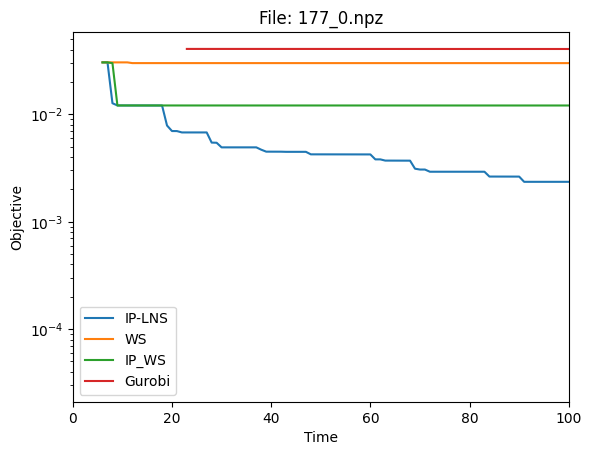

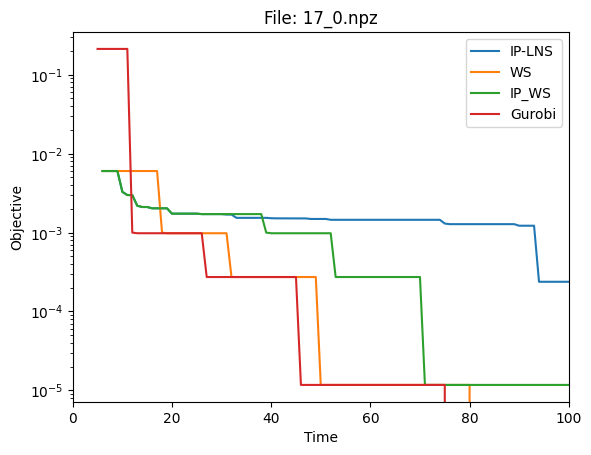

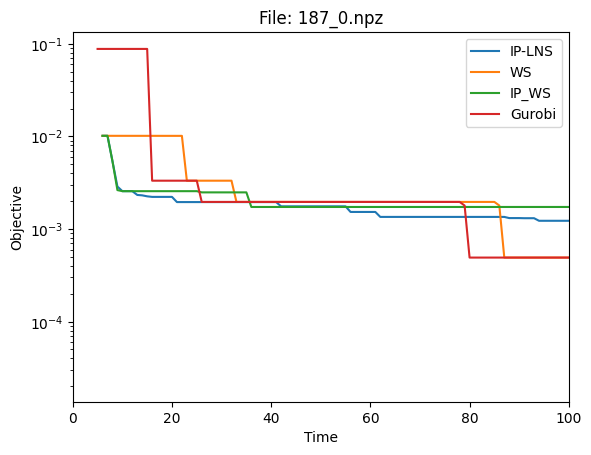

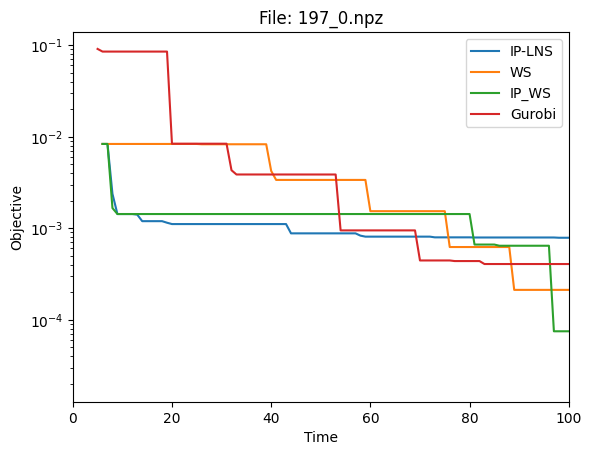

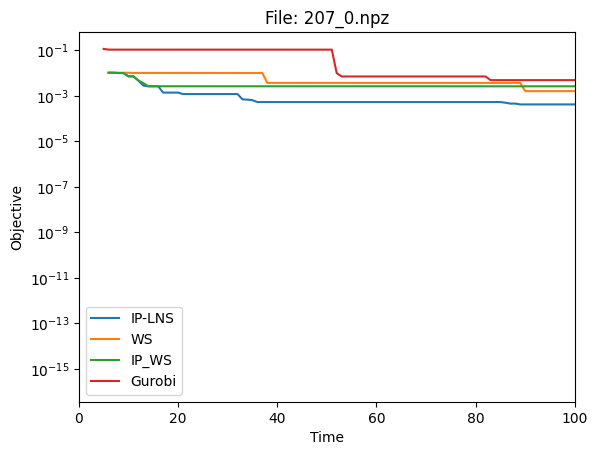

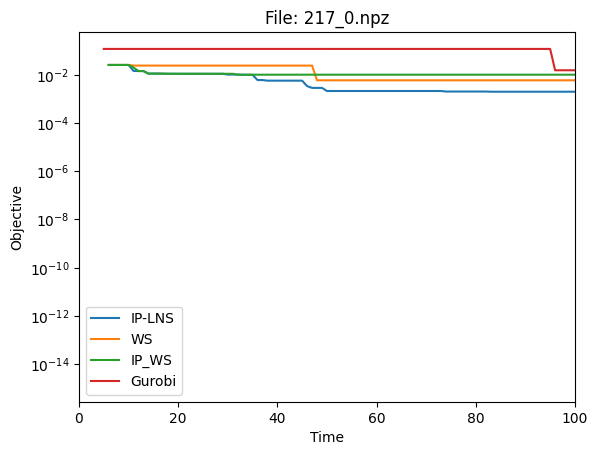

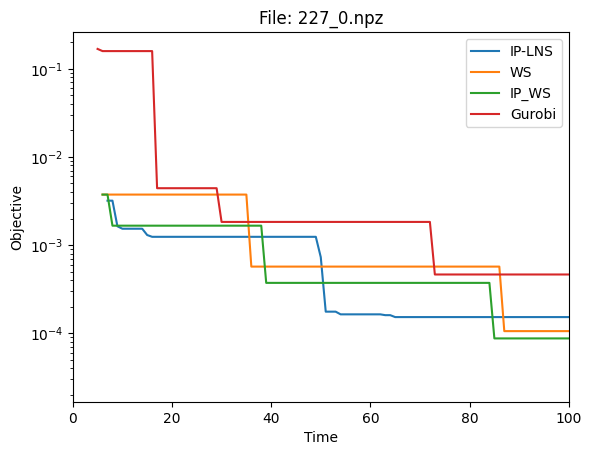

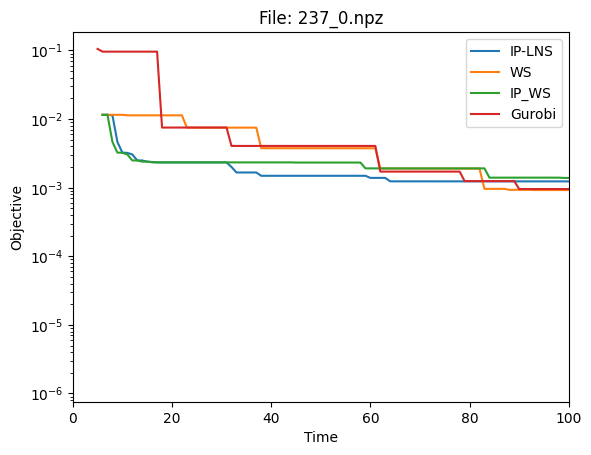

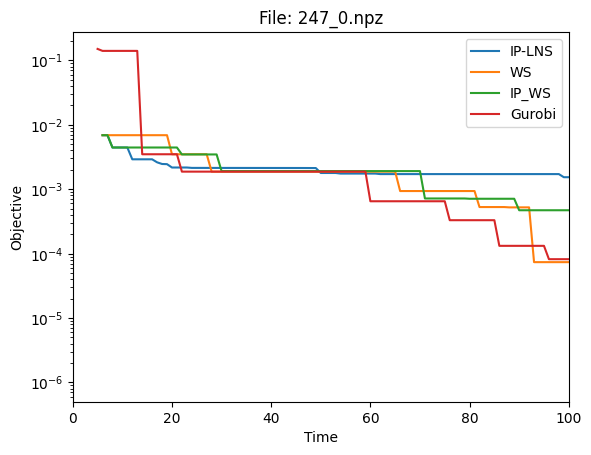

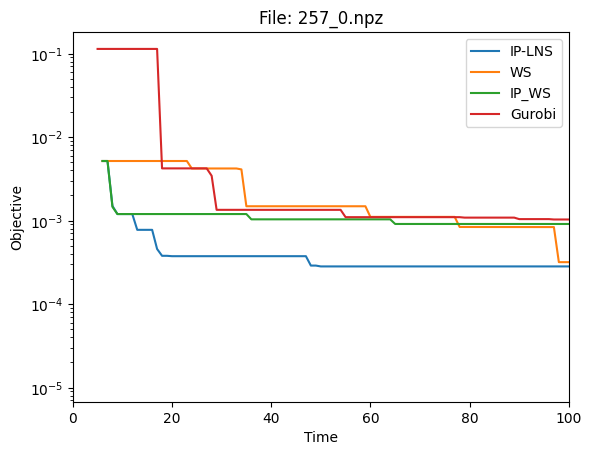

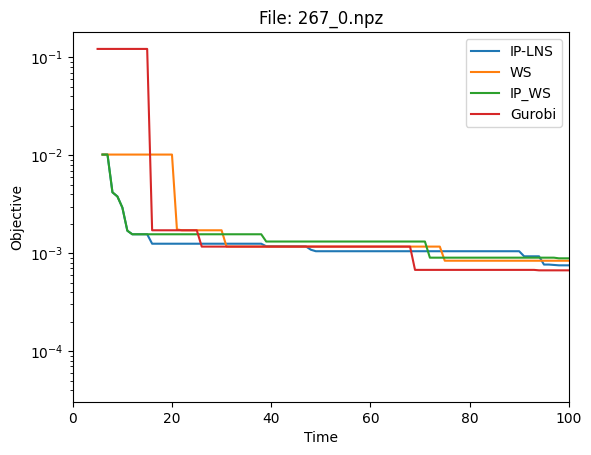

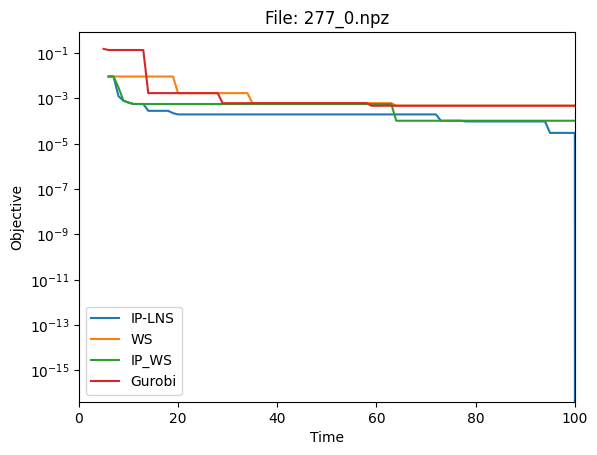

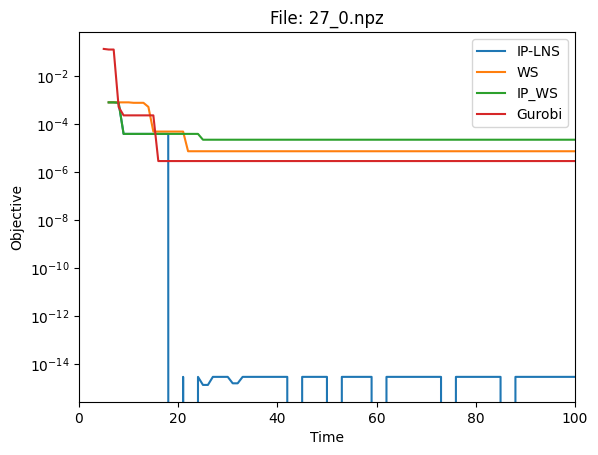

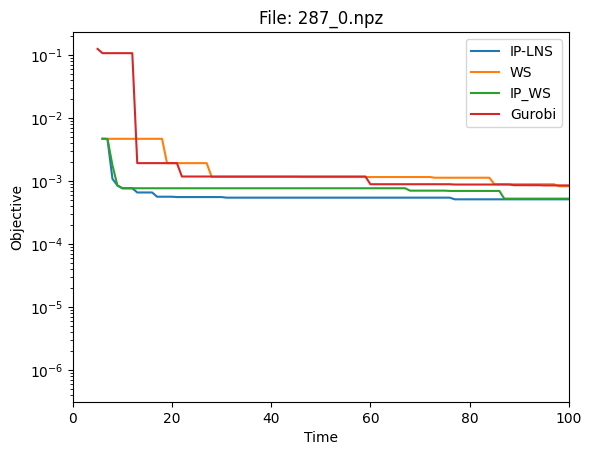

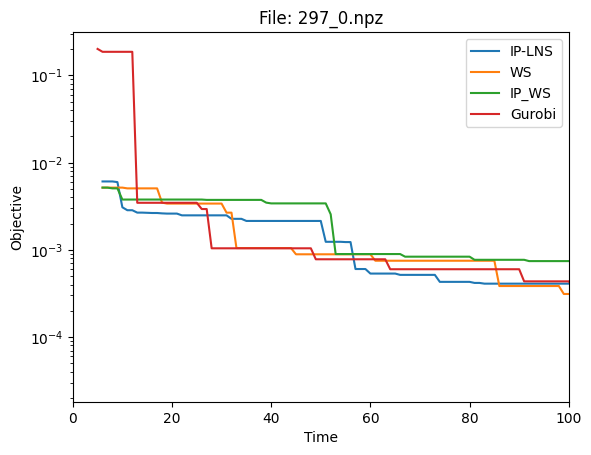

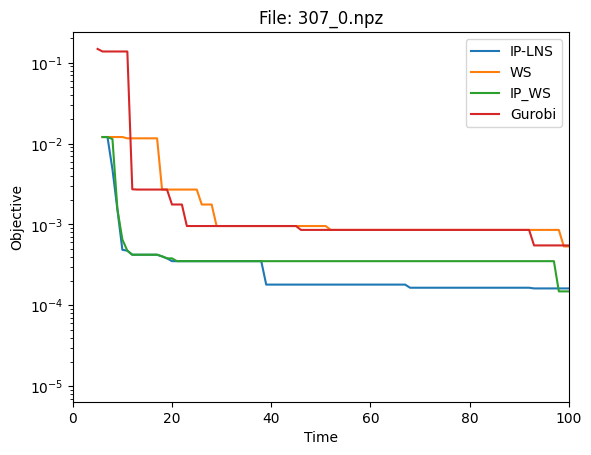

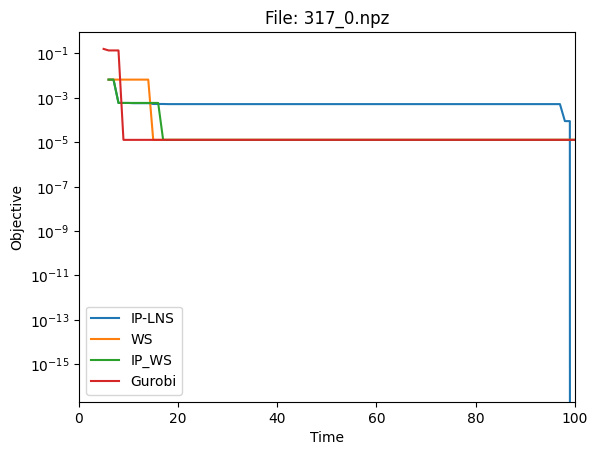

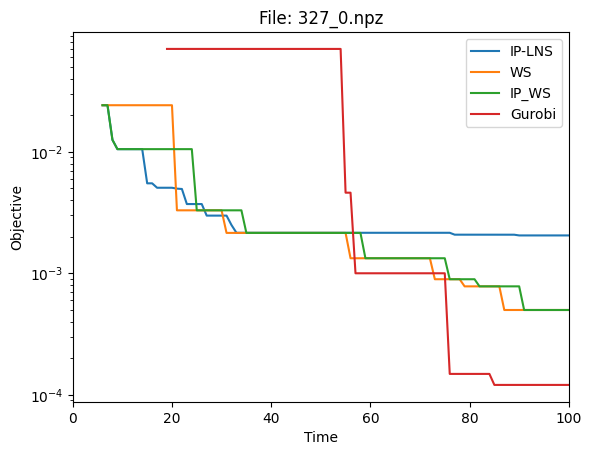

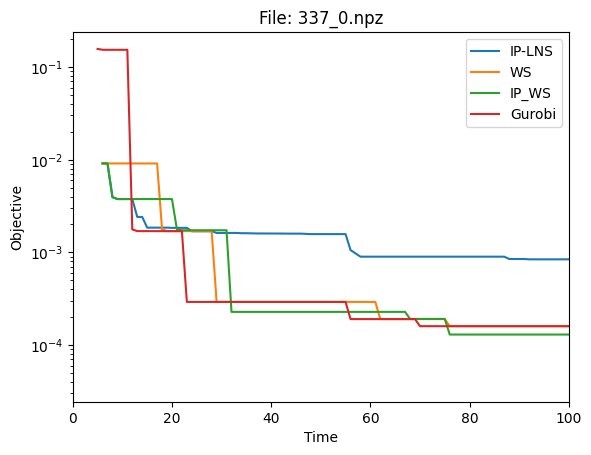

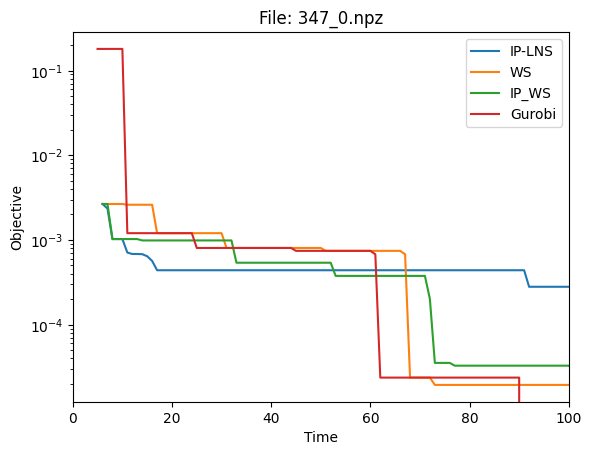

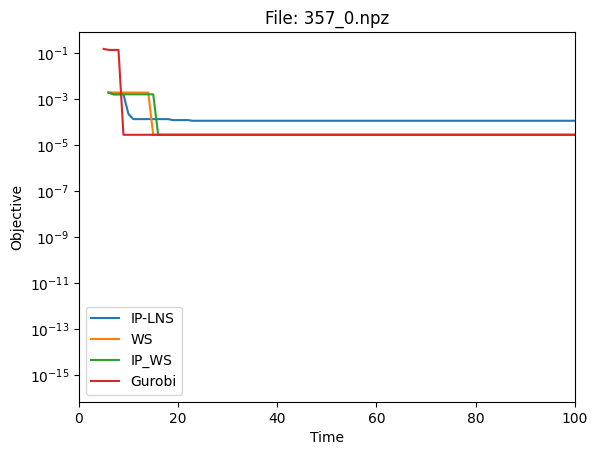

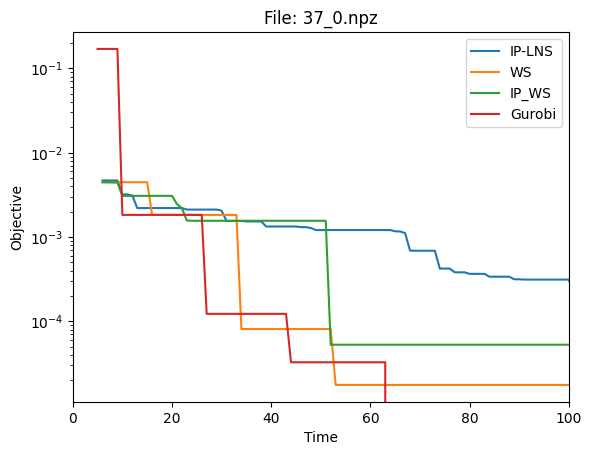

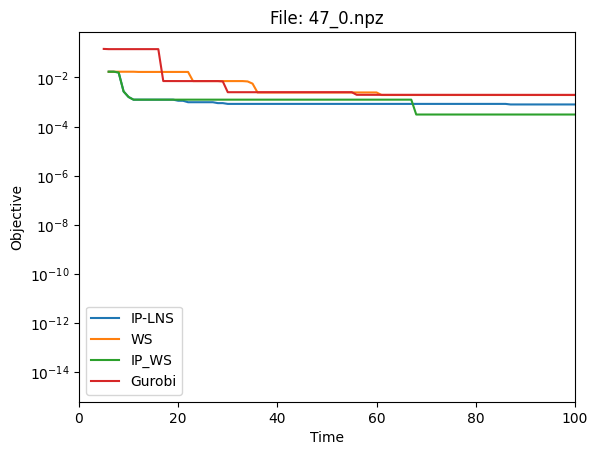

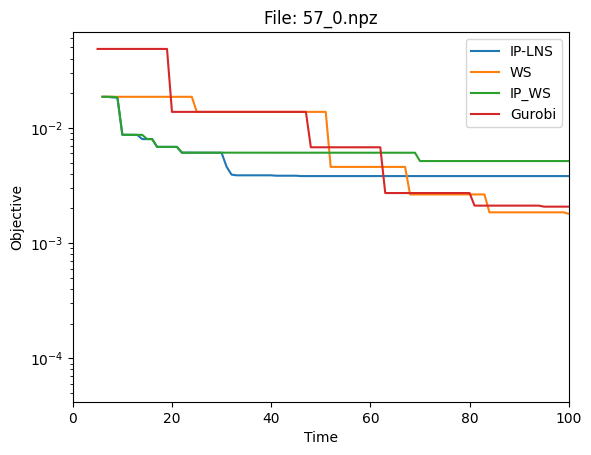

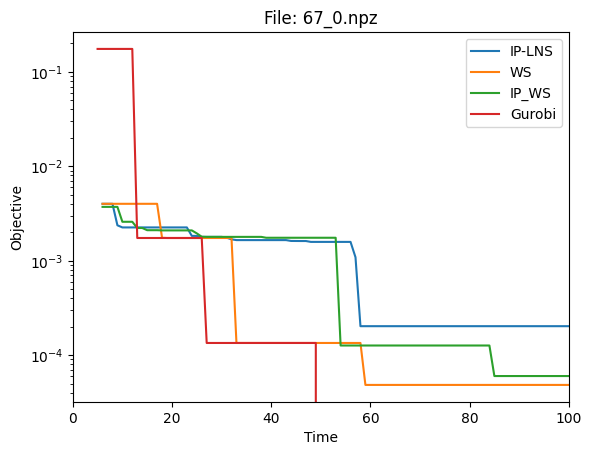

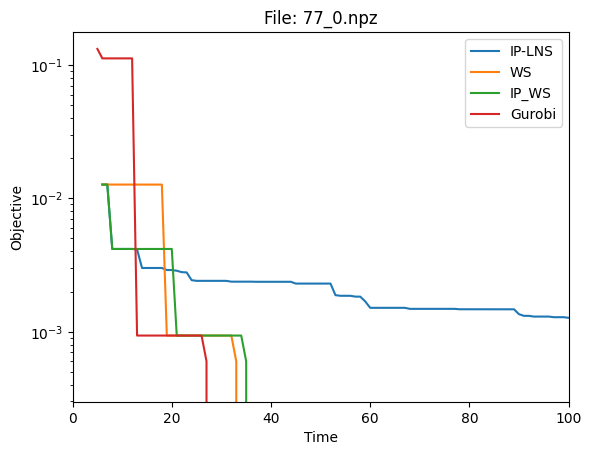

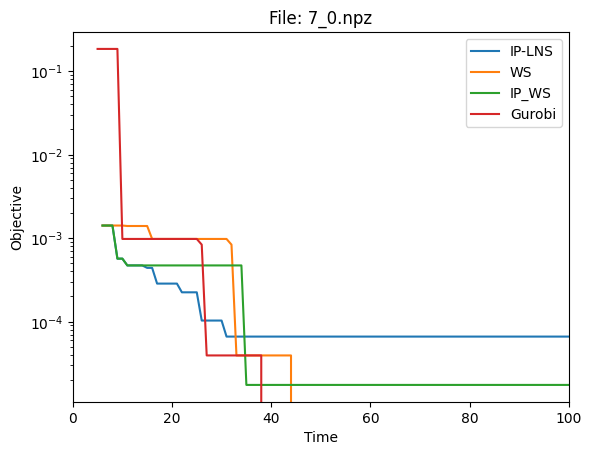

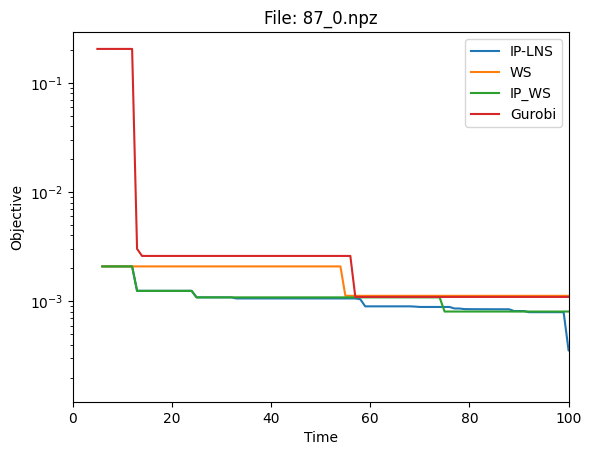

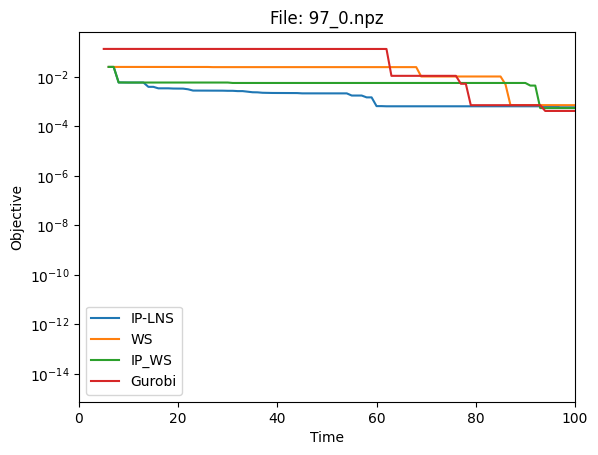

In [9]:
import os
import numpy as np
import matplotlib.pyplot as plt


time_laps = 200
save_paths = ['data_save/IP-LNS','data_save/WS','data_save/IP_WS','data_save/Gurobi']
labels = ['IP-LNS','WS','IP_WS','Gurobi']
files = os.listdir(save_paths[0])

for file in files:
    best_obj = np.inf
    for path,label in zip(save_paths,labels):
        ls_file = os.path.join(path, file)
        ls_result = np.load(ls_file)
        ls_objs = ls_result['obj_round']
        best_obj = min(best_obj,ls_objs[-1])
        

    plt.figure()
    for path in save_paths:
        ls_result = np.load(f'{path}/{file}')
        ls_objs = ls_result['obj_round']
        ls_times = ls_result['time_round']
        gaps = [(obj-best_obj)/best_obj for obj in ls_objs]

        array = np.full((time_laps,1),np.inf)
        last=int(ls_times[0])
        for time, gap in zip(ls_times[1:], gaps[:-1]):
            array[last:int(time)] = gap
            last = int(time)
        array[last:] = gaps[-1]


        # 绘制图形
        plt.plot(list(range(time_laps)), array, label=labels[save_paths.index(path)])
        
        # 添加标题和标签
    plt.title(f'File: {file}')
    plt.xlabel('Time')
    plt.xlim(0, 100)
    plt.ylabel('Objective')
    plt.legend()
    plt.yscale('log')
    # 显示图形
    plt.show()
    

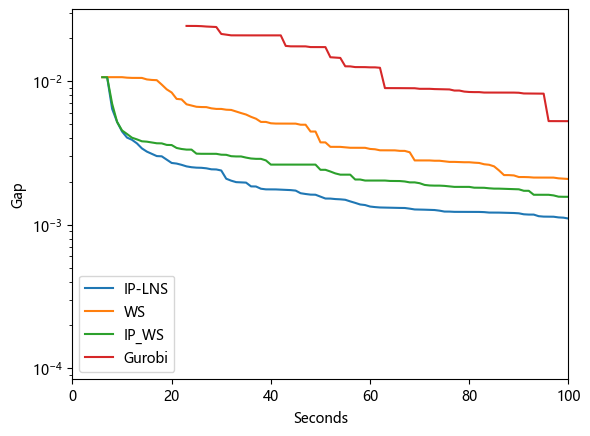

0.0008657082816370917
0.00016866182850760542
0.00011031857290099831
0.00020744607545497543


In [10]:
results = [np.empty((time_laps, 0))]*len(labels)
files = [file for file in files if file[-1] == 'z' and file.split('_')[0][-1]=='7']

avg_time = [[]for _ in range(len(labels))]
for file in files:
    
    # if file in infs:
    #     continue

    best_obj = np.inf
    for path in save_paths:
        ls_file = os.path.join(path, file)
        ls_result = np.load(ls_file)
        ls_times = ls_result['time_round']
        ls_objs = ls_result['obj_round']
        for i in range(len(ls_objs) - 1):
            if ls_objs[i] < ls_objs[i + 1]:
                ls_objs[i + 1] = ls_objs[i]
        if ls_objs[-1]<best_obj:
            best_obj = ls_objs[-1]
    
    
    for i,(path,label) in enumerate(zip(save_paths,labels)):
        ls_file = os.path.join(path, file)
        ls_result = np.load(ls_file)
        ls_times = ls_result['time_round']
        avg_time[i].append(ls_times[0])
        ls_objs = ls_result['obj_round']
        gaps = [(obj-best_obj)/best_obj for obj in ls_objs]
        array = np.full((time_laps,1),np.inf)
        last=int(ls_times[0])
        for time, gap in zip(ls_times[1:], gaps[:-1]):
            array[last:int(time)] = gap
            last = int(time)
        array[last:] = gaps[-1]
        results[i] = np.concatenate((results[i], array), axis=1)
# for i,name in enumerate(labels):
#     print(name,np.mean(avg_time[i]))
results_mean = [np.mean(result, axis=1) for result in results]
# Define x coordinates
x = np.arange(time_laps)

plt.rcParams['font.sans-serif']=['Microsoft YaHei']
for i in range(len(labels)):
    plt.plot(x, results_mean[i], label=labels[i])
# Add legend
plt.xlabel('Seconds')
plt.ylabel('Gap')
plt.yscale('log')
# plt.ylim(0,0.05)
plt.xlim(0,100)
# plt.xscale('log')
# Add legend
plt.legend()

# plt.savefig('search.svg',format='svg')
# Show the plot
plt.show()
for retult in results_mean:
    print(retult[-1])